# Pasos Previos

## Libaries

In [1]:
#Importar Librerías
 
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 10px !important;}</style>"))
import shutil
import random
import glob
from sympy import *
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools as it
from PIL import Image
from IPython.display import clear_output
import random
if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you change the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir
from fastai.tabular.all import *
from skimage import data
from skimage.filters import threshold_multiotsu
import inspect
from sklearn.manifold import TSNE
from sklearn import decomposition
#from sklearn.preprocessing import scaled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import more_itertools
from sklearn.manifold import TSNE
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import imutils
#from time import time
from featurewiz import featurewiz
import time
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2
from urllib.error import HTTPError
#init_printing() # Numeros más bonitos

Notebook directory: /home/gabriel/Desktop
Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


## Functions

In [2]:
def potential_df(symmetry = 'None', with_z = False):

    # Generar un solo potencial, pero le tienes que decir la simetría que 
    # quieres que tenga. por defecto pondrá sin simetría.

    [x_min,x_max]=  [-1,1]
    [y_min,y_max]= [-1,1]
    [z_min,z_max] = [-1,1]
    x_num = 100 # Number of values given to x
    y_num = 100 # Number of values given to y
    z_num = 50 # Number of values given to y
    # inputs es el resultado de emparejar cada x con todas las y
    # Si x = [0,1,2] e y = [a,b], 
    # input = [[0,a],[0,b],[1,a],[1,b],[2,a],[2,b]]


    max_power = 5
    min_power = 1
    count_powers = max_power-min_power+1

    #Una función que te da un array de: [x,x^2,x^3...] entre min_power y max_power
    def powers(var): 
        powers=[]
        for i in range(min_power,max_power+1,1):
            powers.append(var**i)
        return powers

    def V(x,y):
        if symmetry=='continuous_rotation':
            c_i_s = np.random.normal(0,1, size=( count_powers))
            return np.dot(c_i_s,powers(np.sqrt(x**2+y**2)))

        if symmetry=='none':
            c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
            res = np.array([np.dot(np.array(powers(np.array(x[i]))),np.matmul(c_ij_s,powers(y[i]))) for i in range(len(x_s))])
            return res

        if symmetry=='continuous_translation':
            c_i_s = np.random.normal(0,1, size=( count_powers))
            return np.dot(c_i_s,powers(np.random.normal(0,1)*x+np.random.normal(0,1)*y)) 

        if symmetry=='discrete_translation':
            n_s=6
            ni = np.random.choice([-1,1],n_s) * np.random.normal(5,3, n_s)
            return ni[0]*np.sin(ni[1]*(x)+ni[2]*y) +ni[3]*np.cos(ni[4]*x + ni[5]*y)

        if symmetry=='reflection':
            c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
            rn1 = np.random.normal(0,1)
            rn2 = np.random.normal(0,1)
            rn3 = np.random.normal(0,1)
            rn4 = np.random.normal(0,1)
            return np.array([np.dot(powers((rn1*x[i]**2+rn2*y[i]**2)), np.matmul(c_ij_s,powers(rn3*x[i]**2+rn4*y[i]**2))) for i in range(len(x_s))])


    #write a data frame

    if with_z == False:
        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s = inputs.T #Separamos las parejas

        gg = V(x_s,y_s)

        data = {
              'x':x_s,        
              'y':y_s,
              'V':V(x_s,y_s)
              }

        df = pd.DataFrame(data,columns=['x','y','V'])    

    else:

        # Hay que cambiar un  poco el procedimiento para acelerar el proceso y no 
        # calcular x_num*y_num*z_num valores del potencial sino solo x_num*y_num

        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s = inputs.T #Separamos las parejas

        V_temp = V(x_s,y_s)

        V_vals = []

        for v in V_temp:
            V_vals.append([v]*z_num)

        V_vals = np.array(V_vals).flatten()

        inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num),np.linspace(z_min,z_max,z_num))))
        #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
        x_s , y_s, z_s = inputs.T #Separamos las parejas


        data = {
              'x':x_s,        
              'y':y_s,
              'z':z_s,
              'V':V_vals
              }

        df = pd.DataFrame(data,columns=['x','y','z','V'])


        # Para evitar divergencias y no dar tanta importancia a puntos donde el potencial es muy alto
        # agrupamos los puntos del potencial en bines. Intentamos que haya un bin por 
        # punto del potencial, pero hay puntos en los que el potencial
        # vale lo mismo. Agrupamos esos puntos en bines.

    n_attempted_bins =  len(x_s)

    binning = pd.qcut(df.V, q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
    df['bin']=binning[0]
    #n_actual_bins=len(binning[1])-1

    # Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
    df['bin']=df.bin/np.max(df.bin)

    return df


def my_interactions(df, numo_int, verbose = True):
    columnas = list(np.array(df.columns))

    # Cuadrados
    for a in columnas:
        name = a + '**2'
        df[name] = df[a]**2

    if verbose == True: print('All {} columns were squared'.format(len(columnas)))
    if numo_int > len(columnas):
        num_int = len(columnas)
        if verbose == True: print('--> Number of variables smaller than num_int. Using all {} columns'.format(num_int))
    else:
        num_int = numo_int

    columnas_cuad = list(np.array(df.columns))[len(columnas):]

    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

    if num_int > len(columnas_cuad):
        num_int = len(columnas_cuad)
    else:
        num_int = num_int

    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)


    # Productos de variables  axy
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            df[str(ai)+a+'*'+r_sam[i+j+1]] = ai*df[a]*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by products of variables:',k)


    # Cociente de variables  ax/y
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            df[str(ai)+a+'/'+r_sam[i+j+1]] = ai*df[a]/df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by quotient of variables:',k)

    # Product of Random powers
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[a+'^'+str(ai)+'*'+r_sam[i+j+1]+'^'+str(bi)] = df[a]**ai*df[r_sam[i+j+1]]**bi
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by product of variables with random powers:',k)

    '''
    # Exponenciación
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas+columnas_cuad,num_int*2)
    for a,i in zip(r_sam,range(num_int*2)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['exp('+a+')'] = ai*np.exp(df[a])
        k+= 1

    if verbose == True: print('Total number of columns created by exponentiation of variables and squares:',k)

    # Logaritmos
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['log(abs('+a+'))'] = ai*np.log(np.abs(df[a]))
        k+= 1
        
    if verbose == True: print('Total number of columns created by taking log of abs. variables:',k)
    '''
    
    # Raices
    k = 0
    #np.random.seed(int(time.time())+i+1)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        #np.random.seed(int(time.time())+i+j)
        ai = 2*np.random.rand()-1    
        df['sqrt(abs('+a+'))'] = ai*np.sqrt(np.abs(df[a]))
        k+= 1
        
        
    if verbose == True: print('Total number of columns created by taking the square root of abs. variables:',k)

    if verbose == True: print('   Regularising...')
    for a in df.columns:
        df[a] = np.nan_to_num(df[a])



    if verbose == True: print('\n Total number of features:',len(list(np.array(df.columns))))
    
    
    return df

def my_interactions_small(df, numo_int, verbose = True):
    columnas = list(np.array(df.columns))

    # Cuadrados
    for a in columnas:
        name = a + '**2'
        df[name] = df[a]**2

    if verbose == True: print('All {} columns were squared'.format(len(columnas)))
    if numo_int > len(columnas):
        num_int = len(columnas)
        if verbose == True: print('--> Number of variables smaller than num_int. Using all {} columns'.format(num_int))
    else:
        num_int = numo_int

    columnas_cuad = list(np.array(df.columns))[len(columnas):]

    '''    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

        
    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 2*np.random.rand()-1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 2*np.random.rand()-1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)'''
        
        
    # Lineales  ax + by
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination:',k)

        
    # Lineales de cuadrados   ax^2 + by^2
    k = 0
    #np.random.seed(int(time.time())+i)
    r_sam = random.sample(columnas_cuad,num_int)
    for a,i in zip(r_sam,range(num_int)):
        for j in range(num_int-i-1):
            #np.random.seed(int(time.time())+i+j)
            ai = 1
            #np.random.seed(int(time.time())+i+j+1)
            bi = 1
            df[str(ai)+a+'+'+str(bi)+r_sam[i+j+1]] = ai*df[a] + bi*df[r_sam[i+j+1]]
            k+= 1
            #print(a,r_sam[i+j+1])

    if verbose == True: print('Total number of columns created by linear combination of squared variables:',k)
        
        
    if num_int > len(columnas_cuad):
        num_int = len(columnas_cuad)
    else:
        num_int = num_int

    
    if verbose == True: print('   Regularising...')
    for a in df.columns:
        df[a] = np.nan_to_num(df[a])



    if verbose == True: print('\n Total number of features:',len(list(np.array(df.columns))))
    
    
    return df



def fast_feat_imp_rf(df,target, graph = True):
    
    #Tiens un DataFrame con datos en columnas y un objetivo (target) que quieres predecir.
    #target es un string que tiene que ser el nombre de la columna objetivo
    
    def rf(xs, y, n_estimators=100, max_samples=300,
           max_features=0.8, min_samples_leaf=5, **kwargs):
        return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
            max_samples=max_samples, max_features=max_features,
            min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

    # ----- Separar en data + targets -------#
    xs = df.drop(target,axis = 1)
    y = df[[target]]

    # ----Modelo Random Forests ----#
    m = rf(xs, y);
    #print('Accuracy trainig = ', accu(m.predict(xs),y))

    # Feature Importance usando Random Forests
    def rf_feat_importance(m, df):
        return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                           ).sort_values('imp', ascending=False)

    fi = rf_feat_importance(m, xs)

    if graph == True:
        fi.iloc[np.where(fi.imp > 0.01)].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
        plt.title('Feature Importance > 1%. Target = '+target,fontsize = 22)
        plt.show()   
    
    return list(fi.cols), list(fi.imp)


def mock_data(sym = 'reflection',num_bas = 5, plote = False, num_int = 10, verbose = True): 
    # ---------------------------- Opciones -----------------------------------#
    
    #num_bas = 5 # Numero de columnas random
    #plote = False # Mostrar el potencial en gráficas
    #num_int = 10 #Numero de columnas seleccionadas al azar que usamos para interacciones

    #---------------------------------------------------------------------------#
    # Generar Potencial

    df = potential_df(symmetry = sym, with_z = False)
    bins = df.bin # Objetivos: bin
    df = df.drop('V',axis = 1)
    df = df.drop('bin',axis = 1)

    # Añadir columnas de basura
    for i in range(num_bas):
        #np.random.seed(int(time.time())+i)
        name = 'r' + str(i)
        df[name] = 2*np.random.rand(len(df.x))-1

    if verbose == True: print('{} columns with random numbers between [-1,1] were created'.format(i+1))

    if plote == True:
        ax2 = plt.axes(projection='3d')
        ax2.plot_trisurf(df.x, df.y, df.bin, linewidth=0.2, cmap = 'jet')
        plt.title('bin(x,y)')
        plt.show()
        plt.figure()
        plt.scatter(df.x,df.y,c = df.bin,marker = '.', lw = 5)
        
    df_fin = my_interactions(df,num_int, verbose = verbose)
    df_fin['bin'] = bins
    
    return df_fin

# Bases de datos!

In [3]:
# ----------------------------- Lectura Base de datos EES -----------------------------#
link_db = 'https://www.ine.es/ftp/microdatos/salarial/datos_2018.zip'

try:
    r = urllib2.urlopen(link_db).read()
    file = ZipFile(BytesIO(r))
    salaries_csv = file.open('CSV/EES_2018.csv')

    df = pd.read_csv(salaries_csv, sep = '\t', low_memory=False)

except HTTPError:
    print('ERROR: Fichero no encontrado')


df['SALTOTAL'] = df['SALBASE'] + df['COMSAL'] #Lo que cobra cada uno: Salario base + complementos



# ---------------------------------------Embedding using Fastai -----------------------------#
# Categorical variables --> Numerical Variables

# Choice of features
cont_names = ['JAP','HEXTRA','JSP1']
cat_names = ['CNACE', 'CNO1', 'SEXO', 'TIPOPAIS','ESTU','NUTS1','ANOS2']


splits = RandomSplitter(valid_pct=0)(range_of(df))

to = TabularPandas(df,
                procs=[Categorify,FillMissing],
                cat_names = cat_names,
                cont_names = cont_names,
                y_names = 'SALTOTAL',
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e['SALTOTAL'] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)
          


In [4]:
target = 'SALTOTAL'  # Nombre de la variable que queremos predecir
rep_todo = 10        # Veces que se repite todo el algoritmo. Cuantas más veces, más se acerca el promedio a la simetría
nombre_carpeta = 'DB_1' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos anazar al mismo tiempo varias bases de datos

small = True # My Interactions Small (true) or complete (false): Función de interacciones. Small tiene menos combinaciones.


# Tiempo en el que empezamos a ejecutar el código. Hay que importar time así porque existe el módulo time en fastai
from time import time
start_time = time()


tags = [nombre_carpeta for i in range(rep_todo)]

for rtd in range(rep_todo):
    
    df = df_e.copy() # df_e lo hemos creado antes, contiene todas las features que queremos analizar, con las categóricas cambiadas por números (embedding)
    
    from fastai.vision.all import *
    from time import time
    from IPython.utils import io

    int_1 = False      #Interactions in Feature Importance 1 
    int_2 = False      #Interactions in Feature Importance 2 
    select_10k = True  #Keep only 10000 elements of the original DF

    # ------------------- Folder PCA ------------------- #

    folder = 'PCAs_detector_DB'       # Carpeta donde se guardan las subcarpetas con las PCAs

    
    # Si no hay, creamos ese directorio
    dd = top_dir + '/' + folder
    if not os.path.isdir(dd):
        print('Creating directory:\n',dd)
        os.mkdir(dd)

    dir = os.path.join(top_dir,folder)

    
    # ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
    # Solo hay un print que se ha eliminado del código original

    class SaveModelCallback(TrackerCallback):
        "A `TrackerCallback` that saves the model's best during training and loads it at the end."
        _only_train_loop = True
        def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                     with_opt=False, reset_on_fit=True):
            super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
            assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
            # keep track of file path for loggers
            self.last_saved_path = None
            store_attr('fname,every_epoch,at_end,with_opt')

        def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

        def after_epoch(self):
            "Compare the value monitored to its best score and save if best."
            if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
            else: #every improvement
                super().after_epoch()
                if self.new_best:
                    #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                    self._save(f'{self.fname}')

        def after_fit(self, **kwargs):
            "Load the best model."
            if self.at_end: self._save(f'{self.fname}')
            elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

    # ---------------- Definiciones previas e hiperparámetros ----------------- #

    # Hyperparameters: 
    bs_choices = [50000]       # Batch Size
    shape='pipe'               # Shape of the neural network
    layers_choices = [5]       # Number of layers of the net. Default:10 or 5. Better results with 5.
    neurons_choices = [50]    # Number of neurons per layer. Default:200, 100 or 50. Better results with 50.
    epoch_choices = [150]      # Number of training epochs. Default:[100 -> 200]. Better results with 150.
    lr_choices = [0.01]       # Max learning rate. Default 0.01.
    valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
    monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved. Default: 'valid_loss'



    # ---------------------- Entrenar Red Y PCA -----------------------------------#

    j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general


    #----------- Selecting just 10k values -------------#

    if select_10k == True:
        if len(df[target]) <= 100*100:
            print('Too little data to keep 10k points and delete the rest')
        else:
            print('Keeping 10k points of the original DF')
            remove_n = len(df[target]) - 10000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


    #----------- Feature Importance inicial -------------#
    
    print('First Feature importance')

    small_df = df.copy()
    
    n_f = len(small_df)

    
    # Si queremos interacciones en todo el dataframe
    if int_1 == True:

        small_df = small_df.drop(target, axis = 1) # Drop the target
        
        # Interactions
        if small == True: small_df = my_interactions_small(small_df.astype(np.float32), numo_int = int(len(small_df.columns)/2 + 1), verbose = True)
        else: small_df = my_interactions(small_df.astype(np.float32), numo_int = int(len(small_df.columns)/2 + 1), verbose = True)

        small_df[target] = df[target] # Return the target


    #Feature Importance with Random Forests
    best_feat, imp = fast_feat_imp_rf(small_df.astype(np.float32),target = target, graph = False)
    # Correlation of the best variables between them
    cm_rf = small_df[best_feat[:n_f]].corr()
    
    # Función que tiene en cuenta la importancia de las variables y la correlación con la primera más importante
    corr_imp = np.exp(np.array(imp[:n_f]))*((1-np.abs(cm_rf.iloc[:,0])))
    
    # Dos mejores variables: La más importante y la que mejor puntúa en la función anterior
    two_best = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]

    small_df = small_df[two_best]



    #----------- Second Feature Importance (si procede) -------------#
    print('Second Feature importance')
    

    # Con las dos features que hemos seleccionado, podemos hacer muchas interacciones para ver si una combinación de ellas predice
    # mejor el potencial que estas dos features solas. No suele funcionar muy bien para encontrar la simetría.
    if int_2 == True:
        n_f = 10
        small_df = my_interactions(small_df.astype(np.float32), numo_int = len(small_df.columns), verbose = False)

        small_df[target] = df[target]
        best_feat, imp = fast_feat_imp_rf(small_df.astype(np.float32),target = target, graph = False)
        cm_rf = small_df[best_feat[:n_f]].corr()

        corr_imp = np.exp(np.array(imp[:n_f]))*((1-np.abs(cm_rf.iloc[:,0])))

        two_best_2 = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]
    else:
        two_best_2 = two_best


    small_df[target] = df[target] # Devolvemos el target otra vez
  
    print('\n ----> Training with features {} and {} \n'.format(two_best_2[0],two_best_2[1]))

    df2 = small_df.copy() 
    
    # Normalizamos por el valor más grande todas las features y el objetivo
    df2[two_best_2[0]] = df2[two_best_2[0]]/np.max(np.abs(df2[two_best_2[0]]))
    df2[two_best_2[1]] = df2[two_best_2[1]]/np.max(np.abs(df2[two_best_2[1]]))
    df2[target] = df2[target]/np.max(np.abs(df2[target]))

    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

    to = TabularPandas(df2,
                    procs=[Categorify,FillMissing, Normalize],
                    cont_names = two_best_2,
                    y_names = target,
                    splits=splits)

    train_size = len(splits[0])
    valid_size = len(splits[1])

    # ----------------- Hyperparameters ------------------- #

    # Batch Size (a large one)
    bs=min(random.choice(bs_choices),train_size)  
    print('{} batch size for training.\n'.format(bs))

    # Neurons per layer
    neurons_per_layer = random.choice(neurons_choices)

    # Number of layers
    n_layers = random.choice(layers_choices)

    #Shape of the net: Pipe or funnel
    if shape == 'pipe':
        layers=[neurons_per_layer for i in range(n_layers)]

    if shape == 'funnel':
        n_eff = n_layers
        layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

    print('Training FCNN with layers: ',layers)

    #Number of epochs
    n_epoch=random.choice(epoch_choices)
    print('Training for {} epochs.'.format(n_epoch))

    # Maximum Learning Rate: (a good value can be found using learn.lr_find())
    lr_max=float(random.choice(lr_choices))
    print('Using lr_max = ',format(lr_max))

    # ----------------------------------------------------- #

    # --------------- Training the FCNN --------------------#

    # Load the data into a DataLoader
    dls = to.dataloaders(bs=bs)

    # Define a Tabular Learner
    learn = tabular_learner(dls, layers=layers
                        #,config=config
                        #,metrics=[mse],
                        #y_range = [min(df[target]),max(df[target])],
                        #,cbs=ShowGraphCallback()
                        #,train_bn=False)
                        )

    # Train the net 
    with learn.no_logging():
        learn.fit_one_cycle(n_epoch=n_epoch
                            ,lr_max=lr_max
                            ,cbs=[SaveModelCallback(monitor=monitor)]
                            )


    # ------------------------------------------------------#


    # ------------------------- PCA ------------------------#

    test_df = df2.copy()
    dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

    # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
    # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
    with Hooks(learn.model.layers, lambda m,i,o: o) as h:
        preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

    targets=preds[2].numpy().flatten()

    # Cogemos la información de la penúltima capa
    # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
    # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
    act = h.stored[-2] 
    multi_dim=Tensor.cpu(act).numpy()
    standardized=StandardScaler().fit_transform(multi_dim)

    viz = PCA(2).fit_transform(np.nan_to_num(standardized))
    #plt.figure()
    #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')


    # ------------------------------------------------------ #

    # ------------------ Saving the PCA's ------------------ #

    # ---- Dar formato a PCA para guardar como imagen con color

    viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
    viz.columns = ['x','y'] #Nombres de las columnas

    # Insertamos una columna con los colores de los puntos. El valor del potencial
    # objetivo (targets) es el color, y hay un color por cada punto 
    viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

    # ---- Personalizar mapa de color 

    n_classes=1000

    colors = 'rainbow'

    if colors == 'rainbow':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = my_cmap(range(n_classes))
    if colors == 'purple':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

    # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
    #      acumuldos en un pixel

    n_pixels = 224

    binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

    #if we want the pixel intensity to reprensent the number of points at that location
    array = np.dot(binning_3d[0],classes_in_rgb)
    array = array/np.amax(array)

    # ---- Guardar la PCA

    #Directorio donde guardaremos las imagenes
    dir_sym = os.path.join(dir,tags[j-1])
    if not os.path.isdir(dir_sym):
        print('Creating directory:\n',dir_sym)
        os.mkdir(dir_sym)


    # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
    img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'-'+str(n_classes)+'_'+'color_classes--'+'_PCA.png' 
    output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
    plt.imsave(output_dir,array) # Guardar
    print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))

    # ------------------------ Time -------------------------#

    minutes_until_now = (time() - start_time)/60
    images_done = j+rtd
    minutes_per_image = minutes_until_now/(images_done)
    hours_left = minutes_per_image * (rep_todo-images_done)/60
    print("\n{} PCA's made out of {}.\n".format(images_done,rep_todo))
    print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
    print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
    print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,rep_todo-images_done))
    print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,rep_todo-images_done))
    j+=1


  # ------------------------------------------------------#

Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159349-1000_color_classes--_PCA.png


1 PCA's made out of 10.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
1.2 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159354-1000_color_classes--_PCA.png


2 PCA's made out of 10.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
0.9 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159360-1000_color_classes--_PCA.png


3 PCA's made out of 10.

0.3 minutes elapsed for 3 images.
0.1 minutes average per image.
0.7 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159365-1000_color_classes--_PCA.png


4 PCA's made out of 10.

0.4 minutes elapsed for 4 images.
0.1 minutes average per image.
0.6 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159370-1000_color_classes--_PCA.png


5 PCA's made out of 10.

0.5 minutes elapsed for 5 images.
0.1 minutes average per image.
0.5 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159376-1000_color_classes--_PCA.png


6 PCA's made out of 10.

0.6 minutes elapsed for 6 images.
0.1 minutes average per image.
0.4 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159381-1000_color_classes--_PCA.png


7 PCA's made out of 10.

0.7 minutes elapsed for 7 images.
0.1 minutes average per image.
0.3 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159386-1000_color_classes--_PCA.png


8 PCA's made out of 10.

0.8 minutes elapsed for 8 images.
0.1 minutes average per image.
0.2 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JSP1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159392-1000_color_classes--_PCA.png


9 PCA's made out of 10.

0.8 minutes elapsed for 9 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features CNO1 and JAP 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs_detector_DB/DB_1/DB_1_11637159397-1000_color_classes--_PCA.png


10 PCA's made out of 10.

0.9 minutes elapsed for 10 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





Notebook directory: /home/gabriel/Desktop
Numero Imagenes: 20
['DB_1']
['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
[6.11179345e-03 4.34291058e-08 3.99198455e-09 7.34917721e-06
 9.93880811e-01]


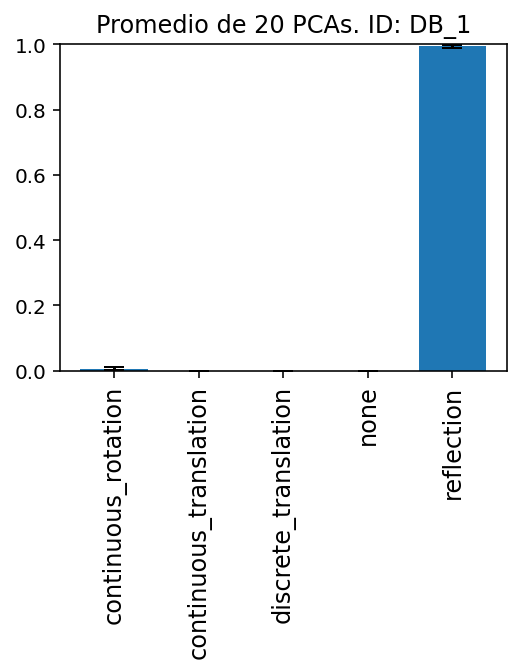

In [5]:
nom_carp = 'PCAs_detector_DB'

#import libraries
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

from time import time
import os
import glob
from fastai.vision.all import *
import numpy as np
from IPython.display import clear_output
import itertools as it
import more_itertools
#import torchvision.models
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default ="none"
import base64
from PIL import Image
from io import BytesIO
import torch
import gc
#import libraries

if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you changed the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir



learn = load_learner('/home/gabriel/Desktop/models/model_90_accu_resnet18_one_cycle_10+5_no_mixup'+'.pkl', cpu=False)
     

#Reset Registro

registro = pd.DataFrame({
    'Col_Quit':[0], 'Run':[0],
    'continuous_rotation':[0], 'continuous_translation':[0], 'discrete_translation':[0], 'none':[0], 'reflection':[0]
})
registro = registro.drop(0)
#registro

sims = pd.DataFrame(columns = learn.dls.vocab)
errs = sims.copy()

num_img_cat = [] #guardo el numero de imagenes de cada categoria
i = 0
plote = False

from IPython.utils import io



for dires in np.sort(Path('/home/gabriel/Desktop/' + nom_carp).ls()):
    #path = Path('/home/gabriel/Desktop/PCA_INE_sexo/INE/'+quitadas)
    quitadas = str(dires).split('/')[-1]
    with io.capture_output() as captured:
        for ima in dires.ls():

            test_im_dir = ima

            im = PILImage.create(test_im_dir)

            # Orden: ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']

            cate, num_cat, probs = learn.predict(im)


            '''
            if plote == True:
                plt.figure
                plt.figure(figsize=(4, 3))
                plt.title(ima)
                plt.bar(['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection'],probs)
                plt.xticks(rotation='vertical',fontsize = 12)
                plt.show()
            '''

            new_row = np.array([quitadas, i] + list(np.array(probs).astype(float))).reshape([1,-1])
            aden = pd.DataFrame(new_row,columns=registro.columns)

            registro = registro.append(aden, ignore_index=True)

            i+=1

    registro = registro.astype({
        'Col_Quit':str, 'Run':int,
        'continuous_rotation':float, 'continuous_translation':float, 'discrete_translation':float, 'none':float, 'reflection':float
    })  

    print('Numero Imagenes:',i)
    num_img_cat.append(i)



#registro.to_csv(r'/home/gabriel/Desktop/PCA_INE_salarios/registro_'+modelo+'.csv', index = False)
print(registro['Col_Quit'].unique())

#registro = pd.read_csv('/home/gabriel/Desktop/PCA_INE_sexo/registro.csv')

nombres_carps = registro['Col_Quit'].unique() #Nombres de las carpetas donde estan guyardadas las pcas de un tipo
num_carps = len(nombres_carps)
i = 0

for nom in nombres_carps:
    if i == 0:
        m_probs = np.array(registro.iloc[:num_img_cat[0],2:].mean())
        err_probs = np.array(registro.iloc[:num_img_cat[0],2:].std())
        nume = str(len(registro.iloc[:num_img_cat[0],2:]))
        print(learn.dls.vocab)
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)
    else:
        m_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].mean())
        err_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].std())
        nume = str(len(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:]))
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)

    if nom == '-ninguna-':
        tit = 'Promedio de '+nume+' PCAs sin quitar ninguna columna'
    else:
        tit = 'Promedio de '+nume+' PCAs. ID: '+ nom        

    
    plt.figure(figsize=(4, 3))
    plt.title(tit)
    #plt.title('Promedio de '+str(40)+' PCAs sin quitar ninguna columna')
    plt.bar(['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection'],
            m_probs,yerr = err_probs/np.sqrt(float(nume)), capsize = 5)
    plt.xticks(rotation='vertical',fontsize = 12)
    plt.ylim([0, 1])
    plt.show()
    
    i+=1

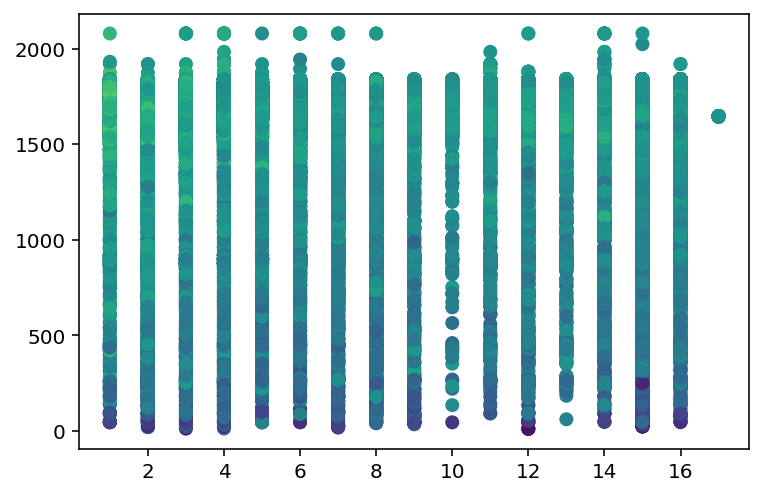

In [7]:
plt.scatter(df_e.CNO1,df_e.JAP, c = np.log(df_e.SALTOTAL*100),marker = 'o')

<AxesSubplot:>

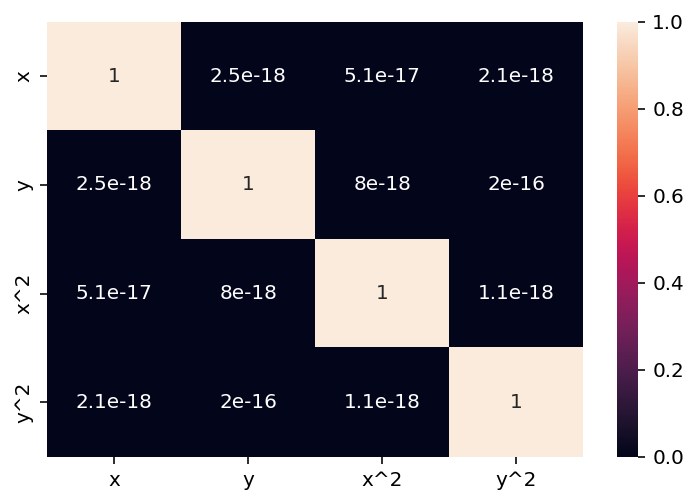

In [15]:
[x_min,x_max]=  [-1,1]
[y_min,y_max]= [-1,1]
x_num = 100 # Number of values given to x
y_num = 100 # Number of values given to y

inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))
#Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
x_s , y_s = inputs.T #Separamos las parejas

df_r = pd.DataFrame({'x':x_s,'y':y_s})

df_r['x^2'] = df_r['x']**2
df_r['y^2'] = df_r['y']**2

sns.heatmap(np.abs(df_r.corr()), annot = True)

In [11]:
df_r.corr()

,x,y,x^2
x,1.000000e+00,2.481184e-18,5.095742e-17
y,2.481184e-18,1.000000e+00,-8.012960e-18
x^2,5.095742e-17,-8.012960e-18,1.000000e+00


# e+e- --> Z --> e+e-

In [3]:
df_e = pd.read_csv('cross-section.csv')

categ = []
numer = []

# ----------------------------------- #

target = 'diff_sigma'
quantiles = True
ignore_list = ['E1', 'Px2', 'Py2', 'Pz2', 'E2', 's', 'cos_theta']


# --------------------------------------#
for col in list(df_e.columns):
    if (col != target) and (col not in ignore_list):
        if type(df_e[col][0]) == str:
            categ.append(col)
        else:
            numer.append(col)

splits = RandomSplitter(valid_pct=0)(range_of(df_e))

to = TabularPandas(df_e,
                procs=[Categorify,FillMissing],
                cat_names = categ,
                cont_names = numer,
                y_names = target,
                splits=splits)


#equiv_CNACE = pd.DataFrame({'Cod_Num':list(to.xs['CNACE'].unique()),'Categ':list(dls.dsets['CNACE'].unique())}).sort_values(by = 'Categ')
#equiv_CNO1 = pd.DataFrame({'Cod_Num':list(to.xs['CNO1'].unique()),'Categ':list(dls.dsets['CNO1'].unique())}).sort_values(by = 'Categ')

df_e = pd.DataFrame(to.xs)
df_e[target] = to.y
df_e = df_e.reset_index().drop('index', axis = 1)  

for col in df_e.columns:
    df_e[col] = np.nan_to_num(df_e[col])   
    if quantiles == True:
        n_attempted_bins =  len(df_e[col])
        binning = pd.qcut(df_e[col], q=n_attempted_bins, retbins=True, labels=False, duplicates='drop')
        df_e[col]=binning[0]/np.max(binning[0])
        df_e[col] = np.nan_to_num(df_e[col])

df_e.head()

,Px1,Py1,Pz1,diff_sigma
0,0.621485,0.946198,0.312733,0.358145
1,0.129325,0.368495,0.788812,0.586554
2,0.242010,0.124065,0.283531,0.419450
3,0.718889,0.577443,0.059882,0.876449
4,0.240270,0.050482,0.470099,0.040470


In [13]:
target = 'diff_sigma'  # Nombre de la variable que queremos predecir
rep_todo = 50        # Veces que se repite todo el algoritmo. Cuantas más veces, más se acerca el promedio a la simetría
nombre_carpeta = 'Z_e+e-_1' # Nombre de la subcarpeta donde vamos a guardar las PCAs, dentro de la carpeta grande. Así podemos anazar al mismo tiempo varias bases de datos

small = True # My Interactions Small (true) or complete (false): Función de interacciones. Small tiene menos combinaciones.


# Tiempo en el que empezamos a ejecutar el código. Hay que importar time así porque existe el módulo time en fastai
from time import time
start_time = time()


tags = [nombre_carpeta for i in range(rep_todo)]

for rtd in range(rep_todo):
    
    df = df_e.copy() # df_e lo hemos creado antes, contiene todas las features que queremos analizar, con las categóricas cambiadas por números (embedding)
    
    from fastai.vision.all import *
    from time import time
    from IPython.utils import io

    int_1 = False      #Interactions in Feature Importance 1 
    int_2 = False      #Interactions in Feature Importance 2 
    select_10k = True  #Keep only 10000 elements of the original DF

    # ------------------- Folder PCA ------------------- #

    folder = 'Z_e+e-_1'       # Carpeta donde se guardan las subcarpetas con las PCAs

    
    # Si no hay, creamos ese directorio
    dd = top_dir + '/' + folder
    if not os.path.isdir(dd):
        print('Creating directory:\n',dd)
        os.mkdir(dd)

    dir = os.path.join(top_dir,folder)

    
    # ------------------- No prints al guardar mejor modelo (fastai) ------------------- # 
    # Solo hay un print que se ha eliminado del código original

    class SaveModelCallback(TrackerCallback):
        "A `TrackerCallback` that saves the model's best during training and loads it at the end."
        _only_train_loop = True
        def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                     with_opt=False, reset_on_fit=True):
            super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
            assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
            # keep track of file path for loggers
            self.last_saved_path = None
            store_attr('fname,every_epoch,at_end,with_opt')

        def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

        def after_epoch(self):
            "Compare the value monitored to its best score and save if best."
            if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
            else: #every improvement
                super().after_epoch()
                if self.new_best:
                    #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                    self._save(f'{self.fname}')

        def after_fit(self, **kwargs):
            "Load the best model."
            if self.at_end: self._save(f'{self.fname}')
            elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

    # ---------------- Definiciones previas e hiperparámetros ----------------- #

    # Hyperparameters: 
    bs_choices = [50000]       # Batch Size
    shape='pipe'               # Shape of the neural network
    layers_choices = [5]       # Number of layers of the net. Default:10 or 5. Better results with 5.
    neurons_choices = [50]    # Number of neurons per layer. Default:200, 100 or 50. Better results with 50.
    epoch_choices = [150]      # Number of training epochs. Default:[100 -> 200]. Better results with 150.
    lr_choices = [0.01]       # Max learning rate. Default 0.01.
    valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
    monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved. Default: 'valid_loss'



    # ---------------------- Entrenar Red Y PCA -----------------------------------#

    j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general


    #----------- Selecting just 10k values -------------#

    if select_10k == True:
        if len(df[target]) <= 100*100:
            print('Too little data to keep 10k points and delete the rest')
        else:
            print('Keeping 10k points of the original DF')
            remove_n = len(df[target]) - 10000
            drop_indices = np.random.choice(df.index, remove_n, replace=False)
            df_temp = df.drop(drop_indices)
            df = df_temp.copy()


    #----------- Feature Importance inicial -------------#
    
    print('First Feature importance')

    small_df = df.copy()
    
    n_f = len(small_df)

    
    # Si queremos interacciones en todo el dataframe
    if int_1 == True:

        small_df = small_df.drop(target, axis = 1) # Drop the target
        
        # Interactions
        if small == True: small_df = my_interactions_small(small_df.astype(np.float32), numo_int = int(len(small_df.columns)/2 + 1), verbose = True)
        else: small_df = my_interactions(small_df.astype(np.float32), numo_int = int(len(small_df.columns)/2 + 1), verbose = True)

        small_df[target] = df[target] # Return the target


    #Feature Importance with Random Forests
    best_feat, imp = fast_feat_imp_rf(small_df.astype(np.float32),target = target, graph = False)
    # Correlation of the best variables between them
    cm_rf = small_df[best_feat[:n_f]].corr()
    
    # Función que tiene en cuenta la importancia de las variables y la correlación con la primera más importante
    corr_imp = np.exp(np.array(imp[:n_f]))*((1-np.abs(cm_rf.iloc[:,0])))
    
    # Dos mejores variables: La más importante y la que mejor puntúa en la función anterior
    two_best = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]

    small_df = small_df[two_best]



    #----------- Second Feature Importance (si procede) -------------#
    print('Second Feature importance')
    

    # Con las dos features que hemos seleccionado, podemos hacer muchas interacciones para ver si una combinación de ellas predice
    # mejor el potencial que estas dos features solas. No suele funcionar muy bien para encontrar la simetría.
    if int_2 == True:
        n_f = 10
        small_df = my_interactions(small_df.astype(np.float32), numo_int = len(small_df.columns), verbose = False)

        small_df[target] = df[target]
        best_feat, imp = fast_feat_imp_rf(small_df.astype(np.float32),target = target, graph = False)
        cm_rf = small_df[best_feat[:n_f]].corr()

        corr_imp = np.exp(np.array(imp[:n_f]))*((1-np.abs(cm_rf.iloc[:,0])))

        two_best_2 = [best_feat[0],(corr_imp.iloc[1:].sort_values()).index[-1]]
    else:
        two_best_2 = two_best


    small_df[target] = df[target] # Devolvemos el target otra vez
  
    print('\n ----> Training with features {} and {} \n'.format(two_best_2[0],two_best_2[1]))

    df2 = small_df.copy() 
    
    # Normalizamos por el valor más grande todas las features y el objetivo
    df2[two_best_2[0]] = df2[two_best_2[0]]/np.max(np.abs(df2[two_best_2[0]]))
    df2[two_best_2[1]] = df2[two_best_2[1]]/np.max(np.abs(df2[two_best_2[1]]))
    df2[target] = df2[target]/np.max(np.abs(df2[target]))

    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

    to = TabularPandas(df2,
                    procs=[Categorify,FillMissing, Normalize],
                    cont_names = two_best_2,
                    y_names = target,
                    splits=splits)

    train_size = len(splits[0])
    valid_size = len(splits[1])

    # ----------------- Hyperparameters ------------------- #

    # Batch Size (a large one)
    bs=min(random.choice(bs_choices),train_size)  
    print('{} batch size for training.\n'.format(bs))

    # Neurons per layer
    neurons_per_layer = random.choice(neurons_choices)

    # Number of layers
    n_layers = random.choice(layers_choices)

    #Shape of the net: Pipe or funnel
    if shape == 'pipe':
        layers=[neurons_per_layer for i in range(n_layers)]

    if shape == 'funnel':
        n_eff = n_layers
        layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()

    print('Training FCNN with layers: ',layers)

    #Number of epochs
    n_epoch=random.choice(epoch_choices)
    print('Training for {} epochs.'.format(n_epoch))

    # Maximum Learning Rate: (a good value can be found using learn.lr_find())
    lr_max=float(random.choice(lr_choices))
    print('Using lr_max = ',format(lr_max))

    # ----------------------------------------------------- #

    # --------------- Training the FCNN --------------------#

    # Load the data into a DataLoader
    dls = to.dataloaders(bs=bs)

    # Define a Tabular Learner
    learn = tabular_learner(dls, layers=layers
                        #,config=config
                        #,metrics=[mse],
                        #y_range = [min(df[target]),max(df[target])],
                        #,cbs=ShowGraphCallback()
                        #,train_bn=False)
                        )

    # Train the net 
    with learn.no_logging():
        learn.fit_one_cycle(n_epoch=n_epoch
                            ,lr_max=lr_max
                            ,cbs=[SaveModelCallback(monitor=monitor)]
                            )


    # ------------------------------------------------------#


    # ------------------------- PCA ------------------------#

    test_df = df2.copy()
    dl = learn.dls.test_dl(test_df,bs=int(test_df.shape[0])) 

    # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
    # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
    with Hooks(learn.model.layers, lambda m,i,o: o) as h:
        preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

    targets=preds[2].numpy().flatten()

    # Cogemos la información de la penúltima capa
    # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
    # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
    act = h.stored[-2] 
    multi_dim=Tensor.cpu(act).numpy()
    standardized=StandardScaler().fit_transform(multi_dim)

    viz = PCA(2).fit_transform(np.nan_to_num(standardized))
    #plt.figure()
    #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')


    # ------------------------------------------------------ #

    # ------------------ Saving the PCA's ------------------ #

    # ---- Dar formato a PCA para guardar como imagen con color

    viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
    viz.columns = ['x','y'] #Nombres de las columnas

    # Insertamos una columna con los colores de los puntos. El valor del potencial
    # objetivo (targets) es el color, y hay un color por cada punto 
    viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

    # ---- Personalizar mapa de color 

    n_classes=1000

    colors = 'rainbow'

    if colors == 'rainbow':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = my_cmap(range(n_classes))
    if colors == 'purple':
        my_cmap = plt.cm.get_cmap('rainbow', n_classes)
        classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

    # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
    #      acumuldos en un pixel

    n_pixels = 224

    binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))

    #if we want the pixel intensity to reprensent the number of points at that location
    array = np.dot(binning_3d[0],classes_in_rgb)
    array = array/np.amax(array)

    # ---- Guardar la PCA

    #Directorio donde guardaremos las imagenes
    dir_sym = os.path.join(dir,tags[j-1])
    if not os.path.isdir(dir_sym):
        print('Creating directory:\n',dir_sym)
        os.mkdir(dir_sym)


    # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
    img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'-'+str(n_classes)+'_'+'color_classes--'+'_PCA.png' 
    output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
    plt.imsave(output_dir,array) # Guardar
    print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))

    # ------------------------ Time -------------------------#

    minutes_until_now = (time() - start_time)/60
    images_done = j+rtd
    minutes_per_image = minutes_until_now/(images_done)
    hours_left = minutes_per_image * (rep_todo-images_done)/60
    print("\n{} PCA's made out of {}.\n".format(images_done,rep_todo))
    print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
    print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
    print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,rep_todo-images_done))
    print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,rep_todo-images_done))
    j+=1


  # ------------------------------------------------------#

Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277940-1000_color_classes--_PCA.png


1 PCA's made out of 50.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
4.4 minutes estimated left for 49 images.



0.1 hours estimated left for 49 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277946-1000_color_classes--_PCA.png


2 PCA's made out of 50.

0.2 minutes elapsed for 2 images.
0.1 minutes average per image.
4.4 minutes estimated left for 48 images.



0.1 hours estimated left for 48 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277951-1000_color_classes--_PCA.png


3 PCA's made out of 50.

0.3 minutes elapsed for 3 images.
0.1 minutes average per image.
4.3 minutes estimated left for 47 images.



0.1 hours estimated left for 47 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277957-1000_color_classes--_PCA.png


4 PCA's made out of 50.

0.4 minutes elapsed for 4 images.
0.1 minutes average per image.
4.2 minutes estimated left for 46 images.



0.1 hours estimated left for 46 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277962-1000_color_classes--_PCA.png


5 PCA's made out of 50.

0.5 minutes elapsed for 5 images.
0.1 minutes average per image.
4.1 minutes estimated left for 45 images.



0.1 hours estimated left for 45 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277968-1000_color_classes--_PCA.png


6 PCA's made out of 50.

0.6 minutes elapsed for 6 images.
0.1 minutes average per image.
4.0 minutes estimated left for 44 images.



0.1 hours estimated left for 44 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277973-1000_color_classes--_PCA.png


7 PCA's made out of 50.

0.6 minutes elapsed for 7 images.
0.1 minutes average per image.
4.0 minutes estimated left for 43 images.



0.1 hours estimated left for 43 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277979-1000_color_classes--_PCA.png


8 PCA's made out of 50.

0.7 minutes elapsed for 8 images.
0.1 minutes average per image.
3.9 minutes estimated left for 42 images.



0.1 hours estimated left for 42 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277985-1000_color_classes--_PCA.png


9 PCA's made out of 50.

0.8 minutes elapsed for 9 images.
0.1 minutes average per image.
3.8 minutes estimated left for 41 images.



0.1 hours estimated left for 41 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277990-1000_color_classes--_PCA.png


10 PCA's made out of 50.

0.9 minutes elapsed for 10 images.
0.1 minutes average per image.
3.7 minutes estimated left for 40 images.



0.1 hours estimated left for 40 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638277996-1000_color_classes--_PCA.png


11 PCA's made out of 50.

1.0 minutes elapsed for 11 images.
0.1 minutes average per image.
3.6 minutes estimated left for 39 images.



0.1 hours estimated left for 39 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278001-1000_color_classes--_PCA.png


12 PCA's made out of 50.

1.1 minutes elapsed for 12 images.
0.1 minutes average per image.
3.5 minutes estimated left for 38 images.



0.1 hours estimated left for 38 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278007-1000_color_classes--_PCA.png


13 PCA's made out of 50.

1.2 minutes elapsed for 13 images.
0.1 minutes average per image.
3.5 minutes estimated left for 37 images.



0.1 hours estimated left for 37 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278013-1000_color_classes--_PCA.png


14 PCA's made out of 50.

1.3 minutes elapsed for 14 images.
0.1 minutes average per image.
3.4 minutes estimated left for 36 images.



0.1 hours estimated left for 36 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278019-1000_color_classes--_PCA.png


15 PCA's made out of 50.

1.4 minutes elapsed for 15 images.
0.1 minutes average per image.
3.3 minutes estimated left for 35 images.



0.1 hours estimated left for 35 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278024-1000_color_classes--_PCA.png


16 PCA's made out of 50.

1.5 minutes elapsed for 16 images.
0.1 minutes average per image.
3.2 minutes estimated left for 34 images.



0.1 hours estimated left for 34 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278029-1000_color_classes--_PCA.png


17 PCA's made out of 50.

1.6 minutes elapsed for 17 images.
0.1 minutes average per image.
3.1 minutes estimated left for 33 images.



0.1 hours estimated left for 33 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278035-1000_color_classes--_PCA.png


18 PCA's made out of 50.

1.7 minutes elapsed for 18 images.
0.1 minutes average per image.
3.0 minutes estimated left for 32 images.



0.0 hours estimated left for 32 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278041-1000_color_classes--_PCA.png


19 PCA's made out of 50.

1.8 minutes elapsed for 19 images.
0.1 minutes average per image.
2.9 minutes estimated left for 31 images.



0.0 hours estimated left for 31 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278046-1000_color_classes--_PCA.png


20 PCA's made out of 50.

1.9 minutes elapsed for 20 images.
0.1 minutes average per image.
2.8 minutes estimated left for 30 images.



0.0 hours estimated left for 30 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278052-1000_color_classes--_PCA.png


21 PCA's made out of 50.

2.0 minutes elapsed for 21 images.
0.1 minutes average per image.
2.7 minutes estimated left for 29 images.



0.0 hours estimated left for 29 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278058-1000_color_classes--_PCA.png


22 PCA's made out of 50.

2.0 minutes elapsed for 22 images.
0.1 minutes average per image.
2.6 minutes estimated left for 28 images.



0.0 hours estimated left for 28 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278063-1000_color_classes--_PCA.png


23 PCA's made out of 50.

2.1 minutes elapsed for 23 images.
0.1 minutes average per image.
2.5 minutes estimated left for 27 images.



0.0 hours estimated left for 27 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278069-1000_color_classes--_PCA.png


24 PCA's made out of 50.

2.2 minutes elapsed for 24 images.
0.1 minutes average per image.
2.4 minutes estimated left for 26 images.



0.0 hours estimated left for 26 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278074-1000_color_classes--_PCA.png


25 PCA's made out of 50.

2.3 minutes elapsed for 25 images.
0.1 minutes average per image.
2.3 minutes estimated left for 25 images.



0.0 hours estimated left for 25 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278079-1000_color_classes--_PCA.png


26 PCA's made out of 50.

2.4 minutes elapsed for 26 images.
0.1 minutes average per image.
2.2 minutes estimated left for 24 images.



0.0 hours estimated left for 24 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278085-1000_color_classes--_PCA.png


27 PCA's made out of 50.

2.5 minutes elapsed for 27 images.
0.1 minutes average per image.
2.1 minutes estimated left for 23 images.



0.0 hours estimated left for 23 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278090-1000_color_classes--_PCA.png


28 PCA's made out of 50.

2.6 minutes elapsed for 28 images.
0.1 minutes average per image.
2.0 minutes estimated left for 22 images.



0.0 hours estimated left for 22 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278096-1000_color_classes--_PCA.png


29 PCA's made out of 50.

2.7 minutes elapsed for 29 images.
0.1 minutes average per image.
1.9 minutes estimated left for 21 images.



0.0 hours estimated left for 21 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278102-1000_color_classes--_PCA.png


30 PCA's made out of 50.

2.8 minutes elapsed for 30 images.
0.1 minutes average per image.
1.9 minutes estimated left for 20 images.



0.0 hours estimated left for 20 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278107-1000_color_classes--_PCA.png


31 PCA's made out of 50.

2.9 minutes elapsed for 31 images.
0.1 minutes average per image.
1.8 minutes estimated left for 19 images.



0.0 hours estimated left for 19 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278113-1000_color_classes--_PCA.png


32 PCA's made out of 50.

3.0 minutes elapsed for 32 images.
0.1 minutes average per image.
1.7 minutes estimated left for 18 images.



0.0 hours estimated left for 18 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278118-1000_color_classes--_PCA.png


33 PCA's made out of 50.

3.1 minutes elapsed for 33 images.
0.1 minutes average per image.
1.6 minutes estimated left for 17 images.



0.0 hours estimated left for 17 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278124-1000_color_classes--_PCA.png


34 PCA's made out of 50.

3.2 minutes elapsed for 34 images.
0.1 minutes average per image.
1.5 minutes estimated left for 16 images.



0.0 hours estimated left for 16 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278130-1000_color_classes--_PCA.png


35 PCA's made out of 50.

3.2 minutes elapsed for 35 images.
0.1 minutes average per image.
1.4 minutes estimated left for 15 images.



0.0 hours estimated left for 15 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278136-1000_color_classes--_PCA.png


36 PCA's made out of 50.

3.3 minutes elapsed for 36 images.
0.1 minutes average per image.
1.3 minutes estimated left for 14 images.



0.0 hours estimated left for 14 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278141-1000_color_classes--_PCA.png


37 PCA's made out of 50.

3.4 minutes elapsed for 37 images.
0.1 minutes average per image.
1.2 minutes estimated left for 13 images.



0.0 hours estimated left for 13 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278146-1000_color_classes--_PCA.png


38 PCA's made out of 50.

3.5 minutes elapsed for 38 images.
0.1 minutes average per image.
1.1 minutes estimated left for 12 images.



0.0 hours estimated left for 12 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278152-1000_color_classes--_PCA.png


39 PCA's made out of 50.

3.6 minutes elapsed for 39 images.
0.1 minutes average per image.
1.0 minutes estimated left for 11 images.



0.0 hours estimated left for 11 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278157-1000_color_classes--_PCA.png


40 PCA's made out of 50.

3.7 minutes elapsed for 40 images.
0.1 minutes average per image.
0.9 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278163-1000_color_classes--_PCA.png


41 PCA's made out of 50.

3.8 minutes elapsed for 41 images.
0.1 minutes average per image.
0.8 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278169-1000_color_classes--_PCA.png


42 PCA's made out of 50.

3.9 minutes elapsed for 42 images.
0.1 minutes average per image.
0.7 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278174-1000_color_classes--_PCA.png


43 PCA's made out of 50.

4.0 minutes elapsed for 43 images.
0.1 minutes average per image.
0.7 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278180-1000_color_classes--_PCA.png


44 PCA's made out of 50.

4.1 minutes elapsed for 44 images.
0.1 minutes average per image.
0.6 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278185-1000_color_classes--_PCA.png


45 PCA's made out of 50.

4.2 minutes elapsed for 45 images.
0.1 minutes average per image.
0.5 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278191-1000_color_classes--_PCA.png


46 PCA's made out of 50.

4.3 minutes elapsed for 46 images.
0.1 minutes average per image.
0.4 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278196-1000_color_classes--_PCA.png


47 PCA's made out of 50.

4.4 minutes elapsed for 47 images.
0.1 minutes average per image.
0.3 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278202-1000_color_classes--_PCA.png


48 PCA's made out of 50.

4.5 minutes elapsed for 48 images.
0.1 minutes average per image.
0.2 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Py1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278208-1000_color_classes--_PCA.png


49 PCA's made out of 50.

4.5 minutes elapsed for 49 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



Keeping 10k points of the original DF
First Feature importance
Second Feature importance

 ----> Training with features Pz1 and Px1 

8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50, 50]
Training for 150 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/Z_e+e-_1/Z_e+e-_1/Z_e+e-_1_11638278213-1000_color_classes--_PCA.png


50 PCA's made out of 50.

4.6 minutes elapsed for 50 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





Notebook directory: /home/gabriel/Desktop
Numero Imagenes: 90
['Z_e+e-_1']
['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']
[0.29182145 0.02794178 0.62747485 0.02896556 0.02379636]


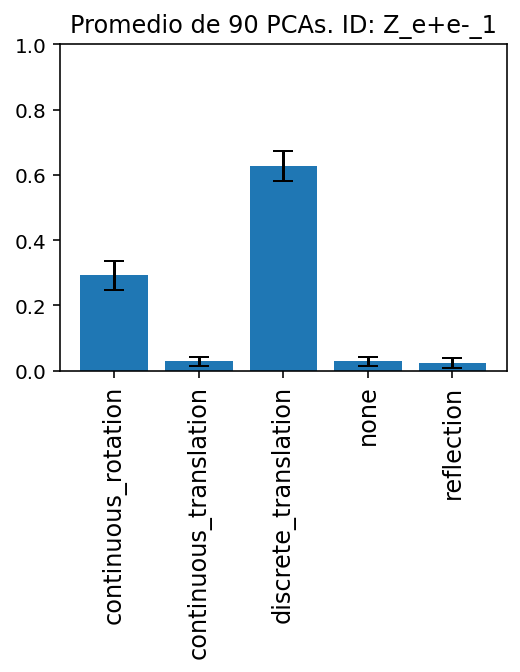

In [14]:
nom_carp = 'Z_e+e-_1'

#import libraries
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

from time import time
import os
import glob
from fastai.vision.all import *
import numpy as np
from IPython.display import clear_output
import itertools as it
import more_itertools
#import torchvision.models
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default ="none"
import base64
from PIL import Image
from io import BytesIO
import torch
import gc
#import libraries

if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you changed the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir



learn = load_learner('/home/gabriel/Desktop/models/model_90_accu_resnet18_one_cycle_10+5_no_mixup'+'.pkl', cpu=False)
     

#Reset Registro

registro = pd.DataFrame({
    'Col_Quit':[0], 'Run':[0],
    'continuous_rotation':[0], 'continuous_translation':[0], 'discrete_translation':[0], 'none':[0], 'reflection':[0]
})
registro = registro.drop(0)
#registro

sims = pd.DataFrame(columns = learn.dls.vocab)
errs = sims.copy()

num_img_cat = [] #guardo el numero de imagenes de cada categoria
i = 0
plote = False

from IPython.utils import io



for dires in np.sort(Path('/home/gabriel/Desktop/' + nom_carp).ls()):
    #path = Path('/home/gabriel/Desktop/PCA_INE_sexo/INE/'+quitadas)
    quitadas = str(dires).split('/')[-1]
    with io.capture_output() as captured:
        for ima in dires.ls():

            test_im_dir = ima

            im = PILImage.create(test_im_dir)

            # Orden: ['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection']

            cate, num_cat, probs = learn.predict(im)


            '''
            if plote == True:
                plt.figure
                plt.figure(figsize=(4, 3))
                plt.title(ima)
                plt.bar(['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection'],probs)
                plt.xticks(rotation='vertical',fontsize = 12)
                plt.show()
            '''

            new_row = np.array([quitadas, i] + list(np.array(probs).astype(float))).reshape([1,-1])
            aden = pd.DataFrame(new_row,columns=registro.columns)

            registro = registro.append(aden, ignore_index=True)

            i+=1

    registro = registro.astype({
        'Col_Quit':str, 'Run':int,
        'continuous_rotation':float, 'continuous_translation':float, 'discrete_translation':float, 'none':float, 'reflection':float
    })  

    print('Numero Imagenes:',i)
    num_img_cat.append(i)



#registro.to_csv(r'/home/gabriel/Desktop/PCA_INE_salarios/registro_'+modelo+'.csv', index = False)
print(registro['Col_Quit'].unique())

#registro = pd.read_csv('/home/gabriel/Desktop/PCA_INE_sexo/registro.csv')

nombres_carps = registro['Col_Quit'].unique() #Nombres de las carpetas donde estan guyardadas las pcas de un tipo
num_carps = len(nombres_carps)
i = 0

for nom in nombres_carps:
    if i == 0:
        m_probs = np.array(registro.iloc[:num_img_cat[0],2:].mean())
        err_probs = np.array(registro.iloc[:num_img_cat[0],2:].std())
        nume = str(len(registro.iloc[:num_img_cat[0],2:]))
        print(learn.dls.vocab)
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)
    else:
        m_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].mean())
        err_probs = np.array(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:].std())
        nume = str(len(registro.iloc[num_img_cat[i-1]:num_img_cat[i],2:]))
        print(m_probs)
        sims = sims.append(pd.DataFrame([m_probs], columns = sims.columns),ignore_index = True)
        errs = errs.append(pd.DataFrame([err_probs/np.sqrt(float(nume))], columns = errs.columns),ignore_index = True)

    if nom == '-ninguna-':
        tit = 'Promedio de '+nume+' PCAs sin quitar ninguna columna'
    else:
        tit = 'Promedio de '+nume+' PCAs. ID: '+ nom        

    
    plt.figure(figsize=(4, 3))
    plt.title(tit)
    #plt.title('Promedio de '+str(40)+' PCAs sin quitar ninguna columna')
    plt.bar(['continuous_rotation', 'continuous_translation', 'discrete_translation', 'none', 'reflection'],
            m_probs,yerr = err_probs/np.sqrt(float(nume)), capsize = 5)
    plt.xticks(rotation='vertical',fontsize = 12)
    plt.ylim([0, 1])
    plt.show()
    
    i+=1